In [1]:
import json
import numpy as np
import ast
import torch
import pandas as pd
from datasets import load_dataset, DatasetDict, Dataset, load_from_disk
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from typing import List, Dict
from collections import defaultdict
from fuzzywuzzy import process
from nltk.util import ngrams
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Training

### Model Specifications

In [2]:
label_list = [
    "O",
    "B-MEDICINE_NAME",
    "I-MEDICINE_NAME",
    "B-MEDICINE_DOSAGE",
    "I-MEDICINE_DOSAGE",
    "B-MEDICINE_FREQUENCY",
    "I-MEDICINE_FREQUENCY",
    "B-COURSE_DURATION",
    "I-COURSE_DURATION"
]

label_to_id = {label: idx for idx, label in enumerate(label_list)}
id_to_label = {idx: label for label, idx in label_to_id.items()}

num_labels = len(label_list)


### Loss Function and Metrics Computation

In [4]:
from torch.nn import CrossEntropyLoss
import torch
from transformers import Trainer
from sklearn.metrics import precision_recall_fscore_support


class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # Extract labels
        labels = inputs.pop("labels").to(model.device)

        # Forward pass
        outputs = model(**inputs)
        logits = outputs.logits

        # Define class weights with more severe reweighting
        class_weights = torch.tensor(
            [1.0, 100.0, 50.0, 200.0, 75.0, 200.0, 100.0, 200.0, 150.0],  # Amplified weights
            device=logits.device
        )

        # Initialize CrossEntropyLoss
        loss_fn = CrossEntropyLoss(weight=class_weights, ignore_index=-100)

        # Compute loss
        logits = logits.view(-1, logits.size(-1))  # Flatten logits
        labels = labels.view(-1)  # Flatten labels
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss
    
def compute_metrics(p):
    predictions, labels = p
    predictions = predictions.argmax(axis=2)

    # Remove ignored index (-100) and flatten
    true_predictions = [
        [id_to_label[pred] for (pred, label) in zip(prediction, label_set) if label != -100]
        for prediction, label_set in zip(predictions, labels)
    ]
    true_labels = [
        [id_to_label[label] for (pred, label) in zip(prediction, label_set) if label != -100]
        for prediction, label_set in zip(predictions, labels)
    ]

    precision, recall, f1, _ = precision_recall_fscore_support(
        [tag for label in true_labels for tag in label],
        [tag for pred in true_predictions for tag in pred],
        average="weighted"
    )
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In this implementation, we customized the loss function and evaluation metrics to better handle imbalanced data. Specifically, we used a weighted cross-entropy loss in the `WeightedLossTrainer` class, where class weights were manually defined to amplify the importance of underrepresented classes. This ensures the model pays more attention to these classes during training, mitigating the risk of bias towards the majority class. 

For metrics, we defined a `compute_metrics` function that calculates precision, recall, and F1 score with a weighted average. This approach evaluates model performance while accounting for class imbalances, ensuring the metrics reflect the contributions of all classes proportionally. Additionally, ignored labels (e.g., `-100`) were excluded from both loss computation and metric evaluation.

### Training with dataset1

In [32]:
tokenized_dataset1 = load_from_disk('dataset1_512')
split_dataset = tokenized_dataset1.train_test_split(test_size=0.2)
train_and_val_dataset = split_dataset['train']
test_dataset = split_dataset['test']
train_val_split = train_and_val_dataset.train_test_split(test_size=0.25, seed=42)
train_dataset = train_val_split['train']
val_dataset = train_val_split['test']

In [64]:
model = AutoModelForTokenClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels,
    id2label=id_to_label,
    label2id=label_to_id
)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

training_args = TrainingArguments(
    output_dir="./results_1", 
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to=[]
)

trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

trainer.train()

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\LEGION\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\LEGION\AppData\Local\Temp\ipykernel_44568\2442855680.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedLossTrainer(


  0%|          | 0/2375 [00:00<?, ?it/s]

{'loss': 1.4205, 'grad_norm': 3.8504650592803955, 'learning_rate': 4.978947368421053e-05, 'epoch': 0.02}
{'loss': 1.0832, 'grad_norm': 3.424929618835449, 'learning_rate': 4.9578947368421055e-05, 'epoch': 0.04}
{'loss': 0.9997, 'grad_norm': 1.1077806949615479, 'learning_rate': 4.936842105263158e-05, 'epoch': 0.06}
{'loss': 1.0143, 'grad_norm': 6.674701690673828, 'learning_rate': 4.915789473684211e-05, 'epoch': 0.08}
{'loss': 0.9354, 'grad_norm': 3.2465174198150635, 'learning_rate': 4.8947368421052635e-05, 'epoch': 0.11}
{'loss': 0.9086, 'grad_norm': 1.7735705375671387, 'learning_rate': 4.873684210526316e-05, 'epoch': 0.13}
{'loss': 0.8975, 'grad_norm': 2.5437581539154053, 'learning_rate': 4.852631578947369e-05, 'epoch': 0.15}
{'loss': 0.8713, 'grad_norm': 3.483523368835449, 'learning_rate': 4.8315789473684215e-05, 'epoch': 0.17}
{'loss': 0.8402, 'grad_norm': 2.26413631439209, 'learning_rate': 4.8105263157894735e-05, 'epoch': 0.19}
{'loss': 0.934, 'grad_norm': 2.673743963241577, 'learnin

  0%|          | 0/159 [00:00<?, ?it/s]

{'eval_loss': 0.7369598746299744, 'eval_precision': 0.9702331079234788, 'eval_recall': 0.6150706440425459, 'eval_f1': 0.7404745602369137, 'eval_runtime': 22.6706, 'eval_samples_per_second': 111.598, 'eval_steps_per_second': 7.014, 'epoch': 1.0}
{'loss': 0.6524, 'grad_norm': 5.41062068939209, 'learning_rate': 3.989473684210526e-05, 'epoch': 1.01}
{'loss': 0.6866, 'grad_norm': 4.441408157348633, 'learning_rate': 3.968421052631579e-05, 'epoch': 1.03}
{'loss': 0.653, 'grad_norm': 2.364797830581665, 'learning_rate': 3.9473684210526316e-05, 'epoch': 1.05}
{'loss': 0.6405, 'grad_norm': 4.446755409240723, 'learning_rate': 3.926315789473684e-05, 'epoch': 1.07}
{'loss': 0.6782, 'grad_norm': 2.06634783744812, 'learning_rate': 3.905263157894737e-05, 'epoch': 1.09}
{'loss': 0.6274, 'grad_norm': 4.5841193199157715, 'learning_rate': 3.8842105263157896e-05, 'epoch': 1.12}
{'loss': 0.6068, 'grad_norm': 3.5880234241485596, 'learning_rate': 3.863157894736842e-05, 'epoch': 1.14}
{'loss': 0.6543, 'grad_nor

  0%|          | 0/159 [00:00<?, ?it/s]

{'eval_loss': 0.6516088247299194, 'eval_precision': 0.969831253723253, 'eval_recall': 0.7802604843616271, 'eval_f1': 0.8565983268911304, 'eval_runtime': 22.8329, 'eval_samples_per_second': 110.805, 'eval_steps_per_second': 6.964, 'epoch': 2.0}
{'loss': 0.5098, 'grad_norm': 2.8702311515808105, 'learning_rate': 2.9789473684210527e-05, 'epoch': 2.02}
{'loss': 0.5091, 'grad_norm': 3.161241054534912, 'learning_rate': 2.9578947368421057e-05, 'epoch': 2.04}
{'loss': 0.4712, 'grad_norm': 2.8818273544311523, 'learning_rate': 2.9368421052631577e-05, 'epoch': 2.06}
{'loss': 0.4706, 'grad_norm': 3.308574914932251, 'learning_rate': 2.9157894736842107e-05, 'epoch': 2.08}
{'loss': 0.5168, 'grad_norm': 2.973512887954712, 'learning_rate': 2.8947368421052634e-05, 'epoch': 2.11}
{'loss': 0.4756, 'grad_norm': 6.032530784606934, 'learning_rate': 2.8736842105263163e-05, 'epoch': 2.13}
{'loss': 0.4963, 'grad_norm': 3.0437166690826416, 'learning_rate': 2.8526315789473683e-05, 'epoch': 2.15}
{'loss': 0.4976, '

  0%|          | 0/159 [00:00<?, ?it/s]

{'eval_loss': 0.6305006742477417, 'eval_precision': 0.9706972350979406, 'eval_recall': 0.7909645523411322, 'eval_f1': 0.8626439565923811, 'eval_runtime': 23.0539, 'eval_samples_per_second': 109.743, 'eval_steps_per_second': 6.897, 'epoch': 3.0}
{'loss': 0.4243, 'grad_norm': 4.12973690032959, 'learning_rate': 1.9894736842105265e-05, 'epoch': 3.01}
{'loss': 0.3985, 'grad_norm': 3.883939743041992, 'learning_rate': 1.968421052631579e-05, 'epoch': 3.03}
{'loss': 0.3999, 'grad_norm': 7.175058841705322, 'learning_rate': 1.9473684210526315e-05, 'epoch': 3.05}
{'loss': 0.3861, 'grad_norm': 5.047866344451904, 'learning_rate': 1.9263157894736845e-05, 'epoch': 3.07}
{'loss': 0.3578, 'grad_norm': 2.769570827484131, 'learning_rate': 1.9052631578947368e-05, 'epoch': 3.09}
{'loss': 0.4449, 'grad_norm': 3.865830421447754, 'learning_rate': 1.8842105263157894e-05, 'epoch': 3.12}
{'loss': 0.3845, 'grad_norm': 4.657745361328125, 'learning_rate': 1.863157894736842e-05, 'epoch': 3.14}
{'loss': 0.3871, 'grad_

  0%|          | 0/159 [00:00<?, ?it/s]

{'eval_loss': 0.6137491464614868, 'eval_precision': 0.9715002923153256, 'eval_recall': 0.789787257924416, 'eval_f1': 0.8617501191191018, 'eval_runtime': 23.0326, 'eval_samples_per_second': 109.844, 'eval_steps_per_second': 6.903, 'epoch': 4.0}
{'loss': 0.328, 'grad_norm': 2.873960256576538, 'learning_rate': 9.789473684210526e-06, 'epoch': 4.02}
{'loss': 0.329, 'grad_norm': 1.938836693763733, 'learning_rate': 9.578947368421052e-06, 'epoch': 4.04}
{'loss': 0.3301, 'grad_norm': 2.7975308895111084, 'learning_rate': 9.368421052631579e-06, 'epoch': 4.06}
{'loss': 0.3339, 'grad_norm': 3.742765188217163, 'learning_rate': 9.157894736842105e-06, 'epoch': 4.08}
{'loss': 0.2941, 'grad_norm': 3.7884769439697266, 'learning_rate': 8.947368421052632e-06, 'epoch': 4.11}
{'loss': 0.3216, 'grad_norm': 7.582748889923096, 'learning_rate': 8.736842105263158e-06, 'epoch': 4.13}
{'loss': 0.342, 'grad_norm': 4.364507675170898, 'learning_rate': 8.526315789473685e-06, 'epoch': 4.15}
{'loss': 0.352, 'grad_norm': 

  0%|          | 0/159 [00:00<?, ?it/s]

{'eval_loss': 0.675471842288971, 'eval_precision': 0.9712424899998483, 'eval_recall': 0.8135869724655963, 'eval_f1': 0.8767213328151993, 'eval_runtime': 23.1332, 'eval_samples_per_second': 109.367, 'eval_steps_per_second': 6.873, 'epoch': 5.0}
{'train_runtime': 972.1189, 'train_samples_per_second': 39.028, 'train_steps_per_second': 2.443, 'train_loss': 0.5310138018758673, 'epoch': 5.0}


TrainOutput(global_step=2375, training_loss=0.5310138018758673, metrics={'train_runtime': 972.1189, 'train_samples_per_second': 39.028, 'train_steps_per_second': 2.443, 'total_flos': 9914226348257280.0, 'train_loss': 0.5310138018758673, 'epoch': 5.0})

In [65]:
training_metrics = trainer.state.log_history
metrics_df = pd.DataFrame(training_metrics)
eval_metrics_df = metrics_df[metrics_df['eval_loss'].notna()]
eval_metrics_df[['eval_precision', 'eval_recall', 'eval_f1']]

,eval_precision,eval_recall,eval_f1
47,0.970233,0.615071,0.740475
96,0.969831,0.780260,0.856598
144,0.970697,0.790965,0.862644
193,0.971500,0.789787,0.861750
241,0.971242,0.813587,0.876721


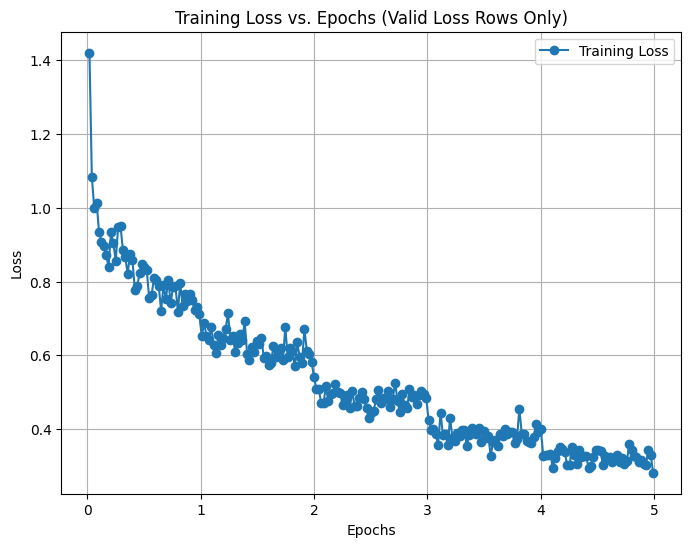

In [66]:
valid_loss_metrics = metrics_df[['epoch', 'loss']].dropna()

plt.figure(figsize=(8, 6))
plt.plot(valid_loss_metrics['epoch'], valid_loss_metrics['loss'], marker='o', label='Training Loss')
plt.title('Training Loss vs. Epochs (Valid Loss Rows Only)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Training with dataset2

In [67]:
tokenized_dataset2 = load_from_disk('dataset2_512')
split_dataset = tokenized_dataset2.train_test_split(test_size=0.2)
train_and_val_dataset = split_dataset['train']
test_dataset = split_dataset['test']
train_val_split = train_and_val_dataset.train_test_split(test_size=0.25, seed=42)
train_dataset = train_val_split['train']
val_dataset = train_val_split['test']

In [68]:
model2 = AutoModelForTokenClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels,
    id2label=id_to_label,
    label2id=label_to_id
)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

training_args = TrainingArguments(
    output_dir="./results_2", 
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to=[]
)

trainer = WeightedLossTrainer(
    model=model2,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

trainer.train()

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\LEGION\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\LEGION\AppData\Local\Temp\ipykernel_44568\3887186420.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedLossTrainer(


  0%|          | 0/2375 [00:00<?, ?it/s]

{'loss': 2.2138, 'grad_norm': 2.193999767303467, 'learning_rate': 4.978947368421053e-05, 'epoch': 0.02}
{'loss': 2.0584, 'grad_norm': 1.880730152130127, 'learning_rate': 4.9578947368421055e-05, 'epoch': 0.04}
{'loss': 1.9932, 'grad_norm': 2.5776801109313965, 'learning_rate': 4.936842105263158e-05, 'epoch': 0.06}
{'loss': 1.9362, 'grad_norm': 4.629258632659912, 'learning_rate': 4.915789473684211e-05, 'epoch': 0.08}
{'loss': 1.8824, 'grad_norm': 3.5678505897521973, 'learning_rate': 4.8947368421052635e-05, 'epoch': 0.11}
{'loss': 1.8836, 'grad_norm': 1.8056176900863647, 'learning_rate': 4.873684210526316e-05, 'epoch': 0.13}
{'loss': 1.8454, 'grad_norm': 2.3711256980895996, 'learning_rate': 4.852631578947369e-05, 'epoch': 0.15}
{'loss': 1.8328, 'grad_norm': 3.3012356758117676, 'learning_rate': 4.8315789473684215e-05, 'epoch': 0.17}
{'loss': 1.8452, 'grad_norm': 2.4056034088134766, 'learning_rate': 4.8105263157894735e-05, 'epoch': 0.19}
{'loss': 1.9087, 'grad_norm': 3.2869603633880615, 'lea

  0%|          | 0/159 [00:00<?, ?it/s]

{'eval_loss': 1.6114007234573364, 'eval_precision': 0.9426162748039032, 'eval_recall': 0.572276055770337, 'eval_f1': 0.7018468972825954, 'eval_runtime': 23.0951, 'eval_samples_per_second': 109.547, 'eval_steps_per_second': 6.885, 'epoch': 1.0}
{'loss': 1.6005, 'grad_norm': 4.841997146606445, 'learning_rate': 3.989473684210526e-05, 'epoch': 1.01}
{'loss': 1.524, 'grad_norm': 3.255918502807617, 'learning_rate': 3.968421052631579e-05, 'epoch': 1.03}
{'loss': 1.5097, 'grad_norm': 3.2256150245666504, 'learning_rate': 3.9473684210526316e-05, 'epoch': 1.05}
{'loss': 1.6071, 'grad_norm': 3.722679615020752, 'learning_rate': 3.926315789473684e-05, 'epoch': 1.07}
{'loss': 1.5682, 'grad_norm': 3.5079901218414307, 'learning_rate': 3.905263157894737e-05, 'epoch': 1.09}
{'loss': 1.5599, 'grad_norm': 3.0925467014312744, 'learning_rate': 3.8842105263157896e-05, 'epoch': 1.12}
{'loss': 1.5344, 'grad_norm': 4.939023971557617, 'learning_rate': 3.863157894736842e-05, 'epoch': 1.14}
{'loss': 1.6623, 'grad_n

  0%|          | 0/159 [00:00<?, ?it/s]

{'eval_loss': 1.4769362211227417, 'eval_precision': 0.9430216817567109, 'eval_recall': 0.6819277016228296, 'eval_f1': 0.7823574994779011, 'eval_runtime': 23.3979, 'eval_samples_per_second': 108.13, 'eval_steps_per_second': 6.795, 'epoch': 2.0}
{'loss': 1.3072, 'grad_norm': 2.794706344604492, 'learning_rate': 2.9789473684210527e-05, 'epoch': 2.02}
{'loss': 1.3489, 'grad_norm': 3.7633159160614014, 'learning_rate': 2.9578947368421057e-05, 'epoch': 2.04}
{'loss': 1.3718, 'grad_norm': 3.7345194816589355, 'learning_rate': 2.9368421052631577e-05, 'epoch': 2.06}
{'loss': 1.2755, 'grad_norm': 3.6023430824279785, 'learning_rate': 2.9157894736842107e-05, 'epoch': 2.08}
{'loss': 1.3002, 'grad_norm': 3.526200294494629, 'learning_rate': 2.8947368421052634e-05, 'epoch': 2.11}
{'loss': 1.275, 'grad_norm': 4.851191997528076, 'learning_rate': 2.8736842105263163e-05, 'epoch': 2.13}
{'loss': 1.3088, 'grad_norm': 4.183913230895996, 'learning_rate': 2.8526315789473683e-05, 'epoch': 2.15}
{'loss': 1.2154, 'g

  0%|          | 0/159 [00:00<?, ?it/s]

{'eval_loss': 1.369285225868225, 'eval_precision': 0.9445686389987215, 'eval_recall': 0.679346072262663, 'eval_f1': 0.7784551940684472, 'eval_runtime': 23.4364, 'eval_samples_per_second': 107.952, 'eval_steps_per_second': 6.784, 'epoch': 3.0}
{'loss': 1.1576, 'grad_norm': 6.3046698570251465, 'learning_rate': 1.9894736842105265e-05, 'epoch': 3.01}
{'loss': 1.1427, 'grad_norm': 4.34046745300293, 'learning_rate': 1.968421052631579e-05, 'epoch': 3.03}
{'loss': 1.0754, 'grad_norm': 4.7276811599731445, 'learning_rate': 1.9473684210526315e-05, 'epoch': 3.05}
{'loss': 1.1382, 'grad_norm': 4.839931488037109, 'learning_rate': 1.9263157894736845e-05, 'epoch': 3.07}
{'loss': 0.9961, 'grad_norm': 3.3271398544311523, 'learning_rate': 1.9052631578947368e-05, 'epoch': 3.09}
{'loss': 1.1037, 'grad_norm': 6.493537902832031, 'learning_rate': 1.8842105263157894e-05, 'epoch': 3.12}
{'loss': 1.103, 'grad_norm': 6.085385799407959, 'learning_rate': 1.863157894736842e-05, 'epoch': 3.14}
{'loss': 1.0938, 'grad_

  0%|          | 0/159 [00:00<?, ?it/s]

{'eval_loss': 1.3291075229644775, 'eval_precision': 0.9459436773239213, 'eval_recall': 0.6945042161936018, 'eval_f1': 0.7884717340338859, 'eval_runtime': 23.3813, 'eval_samples_per_second': 108.206, 'eval_steps_per_second': 6.8, 'epoch': 4.0}
{'loss': 1.001, 'grad_norm': 4.603157997131348, 'learning_rate': 9.789473684210526e-06, 'epoch': 4.02}
{'loss': 0.9653, 'grad_norm': 4.886837005615234, 'learning_rate': 9.578947368421052e-06, 'epoch': 4.04}
{'loss': 0.9848, 'grad_norm': 4.041944980621338, 'learning_rate': 9.368421052631579e-06, 'epoch': 4.06}
{'loss': 0.9848, 'grad_norm': 5.853087902069092, 'learning_rate': 9.157894736842105e-06, 'epoch': 4.08}
{'loss': 0.9915, 'grad_norm': 4.408189296722412, 'learning_rate': 8.947368421052632e-06, 'epoch': 4.11}
{'loss': 0.9773, 'grad_norm': 5.723463535308838, 'learning_rate': 8.736842105263158e-06, 'epoch': 4.13}
{'loss': 0.959, 'grad_norm': 3.4097259044647217, 'learning_rate': 8.526315789473685e-06, 'epoch': 4.15}
{'loss': 0.9468, 'grad_norm': 

  0%|          | 0/159 [00:00<?, ?it/s]

{'eval_loss': 1.3244431018829346, 'eval_precision': 0.9462020228207799, 'eval_recall': 0.6832695366459992, 'eval_f1': 0.7802507276639146, 'eval_runtime': 23.2763, 'eval_samples_per_second': 108.694, 'eval_steps_per_second': 6.831, 'epoch': 5.0}
{'train_runtime': 969.0378, 'train_samples_per_second': 39.152, 'train_steps_per_second': 2.451, 'train_loss': 1.3133700762296978, 'epoch': 5.0}


TrainOutput(global_step=2375, training_loss=1.3133700762296978, metrics={'train_runtime': 969.0378, 'train_samples_per_second': 39.152, 'train_steps_per_second': 2.451, 'total_flos': 9914226348257280.0, 'train_loss': 1.3133700762296978, 'epoch': 5.0})

In [69]:
training_metrics = trainer.state.log_history
metrics_df = pd.DataFrame(training_metrics)
eval_metrics_df = metrics_df[metrics_df['eval_loss'].notna()]
eval_metrics_df[['eval_precision', 'eval_recall', 'eval_f1']]

,eval_precision,eval_recall,eval_f1
47,0.942616,0.572276,0.701847
96,0.943022,0.681928,0.782357
144,0.944569,0.679346,0.778455
193,0.945944,0.694504,0.788472
241,0.946202,0.683270,0.780251


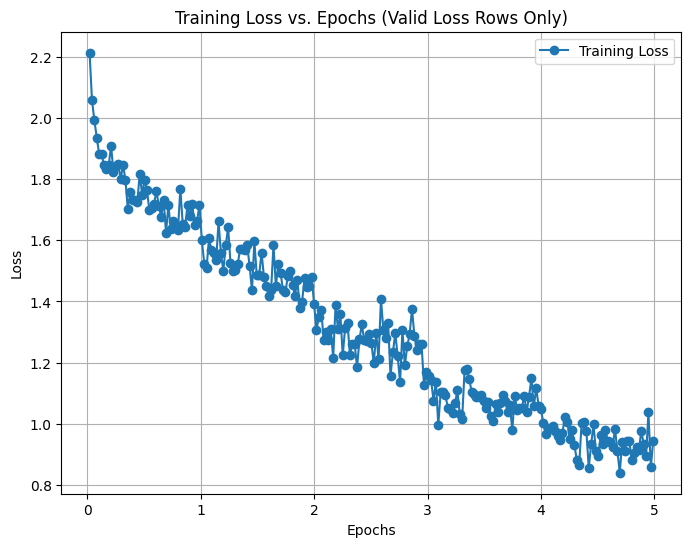

In [70]:
valid_loss_metrics = metrics_df[['epoch', 'loss']].dropna()

plt.figure(figsize=(8, 6))
plt.plot(valid_loss_metrics['epoch'], valid_loss_metrics['loss'], marker='o', label='Training Loss')
plt.title('Training Loss vs. Epochs (Valid Loss Rows Only)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Training with dataset3

In [71]:
tokenized_dataset3 = load_from_disk('dataset3_512')
split_dataset = tokenized_dataset3.train_test_split(test_size=0.2)
train_and_val_dataset = split_dataset['train']
test_dataset = split_dataset['test']
train_val_split = train_and_val_dataset.train_test_split(test_size=0.25, seed=42)
train_dataset = train_val_split['train']
val_dataset = train_val_split['test']

In [73]:
model3 = AutoModelForTokenClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels,
    id2label=id_to_label,
    label2id=label_to_id
)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

training_args = TrainingArguments(
    output_dir="./results_3", 
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to=[]
)

trainer = WeightedLossTrainer(
    model=model3,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

trainer.train()

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\LEGION\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\LEGION\AppData\Local\Temp\ipykernel_44568\2827797522.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedLossTrainer(


  0%|          | 0/2375 [00:00<?, ?it/s]

{'loss': 1.4062, 'grad_norm': 4.574770927429199, 'learning_rate': 4.978947368421053e-05, 'epoch': 0.02}
{'loss': 1.0872, 'grad_norm': 4.659997940063477, 'learning_rate': 4.9578947368421055e-05, 'epoch': 0.04}
{'loss': 0.9712, 'grad_norm': 1.2429327964782715, 'learning_rate': 4.936842105263158e-05, 'epoch': 0.06}
{'loss': 0.9731, 'grad_norm': 2.232450246810913, 'learning_rate': 4.915789473684211e-05, 'epoch': 0.08}
{'loss': 0.9503, 'grad_norm': 1.6966092586517334, 'learning_rate': 4.8947368421052635e-05, 'epoch': 0.11}
{'loss': 0.8872, 'grad_norm': 2.3492214679718018, 'learning_rate': 4.873684210526316e-05, 'epoch': 0.13}
{'loss': 0.8923, 'grad_norm': 2.431483507156372, 'learning_rate': 4.852631578947369e-05, 'epoch': 0.15}
{'loss': 0.9074, 'grad_norm': 3.8799538612365723, 'learning_rate': 4.8315789473684215e-05, 'epoch': 0.17}
{'loss': 0.8685, 'grad_norm': 1.9571664333343506, 'learning_rate': 4.8105263157894735e-05, 'epoch': 0.19}
{'loss': 0.9015, 'grad_norm': 1.5196362733840942, 'lear

  0%|          | 0/159 [00:00<?, ?it/s]

{'eval_loss': 0.7472153902053833, 'eval_precision': 0.9633244341117913, 'eval_recall': 0.5703017439922229, 'eval_f1': 0.6998745487747399, 'eval_runtime': 23.7411, 'eval_samples_per_second': 106.566, 'eval_steps_per_second': 6.697, 'epoch': 1.0}
{'loss': 0.6868, 'grad_norm': 5.257248878479004, 'learning_rate': 3.989473684210526e-05, 'epoch': 1.01}
{'loss': 0.7018, 'grad_norm': 4.333714962005615, 'learning_rate': 3.968421052631579e-05, 'epoch': 1.03}
{'loss': 0.6633, 'grad_norm': 2.3415427207946777, 'learning_rate': 3.9473684210526316e-05, 'epoch': 1.05}
{'loss': 0.6202, 'grad_norm': 2.0143635272979736, 'learning_rate': 3.926315789473684e-05, 'epoch': 1.07}
{'loss': 0.685, 'grad_norm': 1.7501680850982666, 'learning_rate': 3.905263157894737e-05, 'epoch': 1.09}
{'loss': 0.6462, 'grad_norm': 3.188443422317505, 'learning_rate': 3.8842105263157896e-05, 'epoch': 1.12}
{'loss': 0.6193, 'grad_norm': 2.231539249420166, 'learning_rate': 3.863157894736842e-05, 'epoch': 1.14}
{'loss': 0.6616, 'grad_

  0%|          | 0/159 [00:00<?, ?it/s]

{'eval_loss': 0.6466888189315796, 'eval_precision': 0.963615512461816, 'eval_recall': 0.7403339873622277, 'eval_f1': 0.8256723073090876, 'eval_runtime': 23.5693, 'eval_samples_per_second': 107.343, 'eval_steps_per_second': 6.746, 'epoch': 2.0}
{'loss': 0.5715, 'grad_norm': 2.513854742050171, 'learning_rate': 2.9789473684210527e-05, 'epoch': 2.02}
{'loss': 0.5465, 'grad_norm': 3.4294283390045166, 'learning_rate': 2.9578947368421057e-05, 'epoch': 2.04}
{'loss': 0.4837, 'grad_norm': 2.516517162322998, 'learning_rate': 2.9368421052631577e-05, 'epoch': 2.06}
{'loss': 0.4961, 'grad_norm': 4.732661247253418, 'learning_rate': 2.9157894736842107e-05, 'epoch': 2.08}
{'loss': 0.5287, 'grad_norm': 2.402632474899292, 'learning_rate': 2.8947368421052634e-05, 'epoch': 2.11}
{'loss': 0.4964, 'grad_norm': 4.4954376220703125, 'learning_rate': 2.8736842105263163e-05, 'epoch': 2.13}
{'loss': 0.4873, 'grad_norm': 3.4511630535125732, 'learning_rate': 2.8526315789473683e-05, 'epoch': 2.15}
{'loss': 0.5296, '

  0%|          | 0/159 [00:00<?, ?it/s]

{'eval_loss': 0.6468543410301208, 'eval_precision': 0.9642791654128076, 'eval_recall': 0.7678833639988905, 'eval_f1': 0.8439081641854284, 'eval_runtime': 23.688, 'eval_samples_per_second': 106.805, 'eval_steps_per_second': 6.712, 'epoch': 3.0}
{'loss': 0.454, 'grad_norm': 3.3531954288482666, 'learning_rate': 1.9894736842105265e-05, 'epoch': 3.01}
{'loss': 0.4296, 'grad_norm': 4.837594509124756, 'learning_rate': 1.968421052631579e-05, 'epoch': 3.03}
{'loss': 0.3924, 'grad_norm': 3.4070165157318115, 'learning_rate': 1.9473684210526315e-05, 'epoch': 3.05}
{'loss': 0.3998, 'grad_norm': 2.933945894241333, 'learning_rate': 1.9263157894736845e-05, 'epoch': 3.07}
{'loss': 0.3862, 'grad_norm': 2.8279061317443848, 'learning_rate': 1.9052631578947368e-05, 'epoch': 3.09}
{'loss': 0.4691, 'grad_norm': 3.7143595218658447, 'learning_rate': 1.8842105263157894e-05, 'epoch': 3.12}
{'loss': 0.432, 'grad_norm': 3.0434322357177734, 'learning_rate': 1.863157894736842e-05, 'epoch': 3.14}
{'loss': 0.4159, 'gr

  0%|          | 0/159 [00:00<?, ?it/s]

{'eval_loss': 0.6502772569656372, 'eval_precision': 0.9646733348160327, 'eval_recall': 0.7781455099771217, 'eval_f1': 0.8502739387038362, 'eval_runtime': 23.5734, 'eval_samples_per_second': 107.324, 'eval_steps_per_second': 6.745, 'epoch': 4.0}
{'loss': 0.3658, 'grad_norm': 3.1791958808898926, 'learning_rate': 9.789473684210526e-06, 'epoch': 4.02}
{'loss': 0.3516, 'grad_norm': 2.1258790493011475, 'learning_rate': 9.578947368421052e-06, 'epoch': 4.04}
{'loss': 0.355, 'grad_norm': 2.903580665588379, 'learning_rate': 9.368421052631579e-06, 'epoch': 4.06}
{'loss': 0.3494, 'grad_norm': 4.085094928741455, 'learning_rate': 9.157894736842105e-06, 'epoch': 4.08}
{'loss': 0.3428, 'grad_norm': 3.8012969493865967, 'learning_rate': 8.947368421052632e-06, 'epoch': 4.11}
{'loss': 0.3662, 'grad_norm': 8.474578857421875, 'learning_rate': 8.736842105263158e-06, 'epoch': 4.13}
{'loss': 0.3259, 'grad_norm': 2.6752471923828125, 'learning_rate': 8.526315789473685e-06, 'epoch': 4.15}
{'loss': 0.3739, 'grad_n

  0%|          | 0/159 [00:00<?, ?it/s]

{'eval_loss': 0.6989627480506897, 'eval_precision': 0.9647539970474049, 'eval_recall': 0.7879673952599446, 'eval_f1': 0.8564793270314188, 'eval_runtime': 23.8397, 'eval_samples_per_second': 106.126, 'eval_steps_per_second': 6.67, 'epoch': 5.0}
{'train_runtime': 996.8003, 'train_samples_per_second': 38.062, 'train_steps_per_second': 2.383, 'train_loss': 0.5467033588509811, 'epoch': 5.0}


TrainOutput(global_step=2375, training_loss=0.5467033588509811, metrics={'train_runtime': 996.8003, 'train_samples_per_second': 38.062, 'train_steps_per_second': 2.383, 'total_flos': 9914226348257280.0, 'train_loss': 0.5467033588509811, 'epoch': 5.0})

In [74]:
training_metrics = trainer.state.log_history
metrics_df = pd.DataFrame(training_metrics)
eval_metrics_df = metrics_df[metrics_df['eval_loss'].notna()]
eval_metrics_df[['eval_precision', 'eval_recall', 'eval_f1']]

,eval_precision,eval_recall,eval_f1
47,0.963324,0.570302,0.699875
96,0.963616,0.740334,0.825672
144,0.964279,0.767883,0.843908
193,0.964673,0.778146,0.850274
241,0.964754,0.787967,0.856479


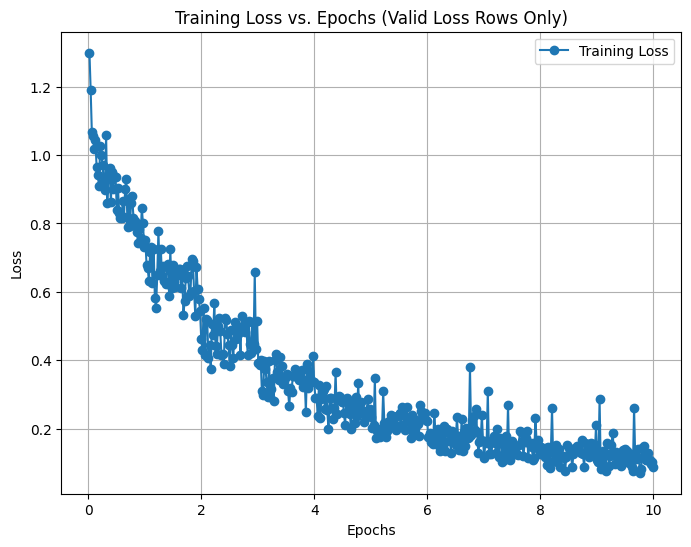

In [ ]:
valid_loss_metrics = metrics_df[['epoch', 'loss']].dropna()

plt.figure(figsize=(8, 6))
plt.plot(valid_loss_metrics['epoch'], valid_loss_metrics['loss'], marker='o', label='Training Loss')
plt.title('Training Loss vs. Epochs (Valid Loss Rows Only)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model1_dir = './trained_model1'
model2_dir = './trained_model2'
model3_dir = './trained_model3'

model.save_pretrained(model1_dir)
model2.save_pretrained(model2_dir)
model3.save_pretrained(model3_dir)